In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt

import time

from keras.models import Sequential#, Graph
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback


/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocessing import load_snp_close, split_into_chunks, create_Xt_Yt

In [3]:
class TrainingHistory(Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.predictions = []
        self.i = 0
        self.save_every = 5000
        
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1
        
        if self.i % self.save_every == 0:
            pred = model.predict(X_train)
            self.predictions.append(pred)

In [4]:
TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

[INFO] Loading SNP Dataset


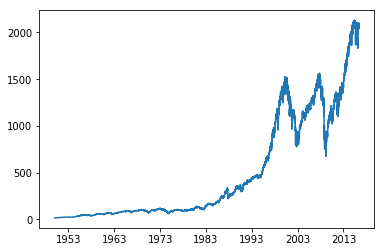

In [5]:
print("[INFO] Loading SNP Dataset")
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [6]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [7]:
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE,
    binary=False, scale=True)

In [8]:
print(len(X))
print(len(timeseries))

16684
16705


In [9]:

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

In [10]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16684, 20)
(16684,)
(15015, 20)
(15015,)
(1669, 20)
(1669,)


In [11]:
Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE,
    binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [12]:
print("[INFO] Building Model")
model = Sequential()
model.add(Dense(500, input_shape=(TRAIN_SIZE,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(250))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')


[INFO] Building Model


In [13]:
X_test.shape

(1669, 20)

In [14]:
from sklearn import preprocessing
print(dates[:20])
print(len(timeseries))
print(range(0, len(timeseries), 1))
print(timeseries[0:20])
print(timeseries[21])
print(np.array(timeseries[0:21]))
series = preprocessing.scale(np.array(timeseries[0:21]))
print(series)
print(series[:-1])
print(series[-1])

[datetime.date(2016, 5, 23), datetime.date(2016, 5, 20), datetime.date(2016, 5, 19), datetime.date(2016, 5, 18), datetime.date(2016, 5, 17), datetime.date(2016, 5, 16), datetime.date(2016, 5, 13), datetime.date(2016, 5, 12), datetime.date(2016, 5, 11), datetime.date(2016, 5, 10), datetime.date(2016, 5, 9), datetime.date(2016, 5, 6), datetime.date(2016, 5, 5), datetime.date(2016, 5, 4), datetime.date(2016, 5, 3), datetime.date(2016, 5, 2), datetime.date(2016, 4, 29), datetime.date(2016, 4, 28), datetime.date(2016, 4, 27), datetime.date(2016, 4, 26)]
16705
range(0, 16705)
[2048.040039, 2052.320068, 2040.040039, 2047.630005, 2047.209961, 2066.659912, 2046.609985, 2064.110107, 2064.459961, 2084.389893, 2058.689941, 2057.139893, 2050.629883, 2051.120117, 2063.370117, 2081.429932, 2065.300049, 2075.810059, 2095.149902, 2091.699951]
2091.580078
[2048.040039 2052.320068 2040.040039 2047.630005 2047.209961 2066.659912
 2046.609985 2064.110107 2064.459961 2084.389893 2058.689941 2057.139893
 205

In [15]:
model.fit(X_train, Y_train, epochs=5, batch_size=128, verbose=1, validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print(score)

Train on 13513 samples, validate on 1502 samples
Epoch 1/5
13513/13513 [==============================] - 1s 58us/step - loss: 0.3444 - val_loss: 0.0866
Epoch 2/5
13513/13513 [==============================] - 1s 49us/step - loss: 0.0754 - val_loss: 0.0119
Epoch 3/5
13513/13513 [==============================] - 1s 48us/step - loss: 0.0389 - val_loss: 0.0068
Epoch 4/5
13513/13513 [==============================] - 1s 48us/step - loss: 0.0286 - val_loss: 0.0048
Epoch 5/5
1669/1669 [==============================] - 0s 14us/step
0.004812607084668239


In [16]:
params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])
    
predicted = model.predict(X_test)
new_predicted = []
for pred, par in zip(predicted, params):
    a = pred * par[1]
    a += par[0]
    new_predicted.append(a)
    
mse = mean_squared_error(predicted, new_predicted)
print(mse)

937.358


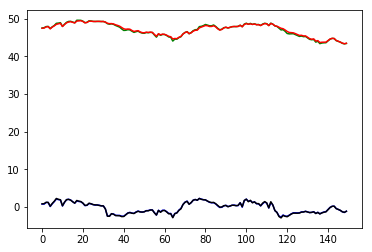

In [17]:
try:
    fig = plt.figure()
    plt.plot(predicted[:150], color='blue')
    plt.plot(Y_test[:150], color='black')
    plt.plot(Y_testp[:150], color='green')
    plt.plot(new_predicted[:150], color='red')
    plt.show()
except Exception as e:
    print(str(e))